# Quantum Entanglement Swapping Protocol

## Swapping an entangled qubit - Simulation

In [186]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel

In [187]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                       not b.configuration().simulator and b.status().operational==True))
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [188]:
backend, noise_model = get_device_noise_model()

ibmqfactory.load_account:WARNING:2023-10-15 12:31:55,907: Credentials are already in use. The existing account in the session will be replaced.


In [189]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibm_nairobi)

Noise Model:
 NoiseModel:
  Basis gates: ['break_loop', 'continue_loop', 'cx', 'for_loop', 'id', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'sx', 'while_loop', 'x']
  Instructions with noise: ['sx', 'measure', 'x', 'cx', 'id', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x

In [190]:

class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister,) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[1], b[0])
        qc.h(a[1])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[1], 0)
        qc.measure(b[0], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b[1]).c_if(bsm_x, 1)
        qc.z(b[1]).c_if(bsm_z, 1)


In [191]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [192]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        result = execute(qc, qasm_sim, shots=10240, noise_model=noise_model).result()
        return result.get_counts()

In [193]:
alice: QuantumRegister = QuantumRegister(2, "alice")
bob: QuantumRegister = QuantumRegister(2, "bob")

bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(alice, bob, bsm_z, bsm_x, coz, cox)

<IPython.core.display.Latex object>

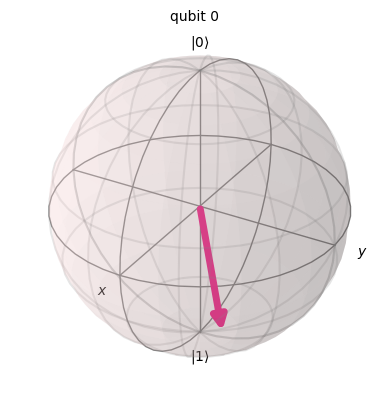

In [194]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qv: QuantumVisualizations = QuantumVisualizations()

psi: Statevector = qco.create_random_statevector(2)

qv.display_statevector_as_array(psi)
qv.display_bloch_statevector(psi)

In [195]:
init_instruction: Initialize = Initialize(psi)
init_instruction.label = "init instruction"

qc.append(init_instruction, [alice[0]])

qco.create_bell_pairs(qc, [alice, bob])

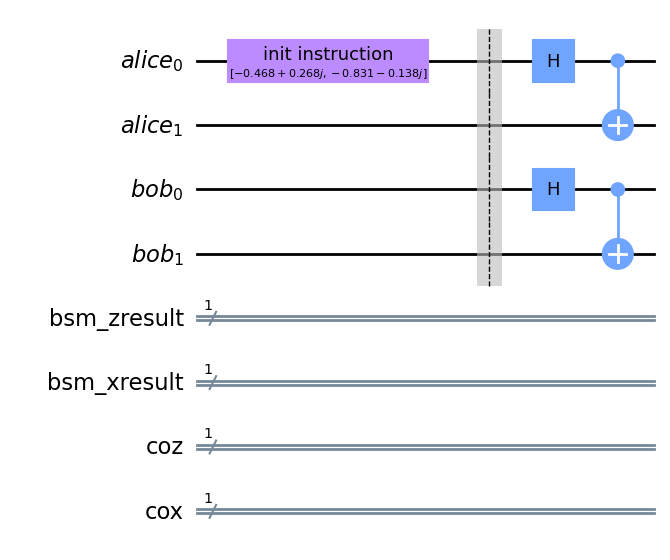

In [196]:
fig = qc.draw("mpl")
fig

<IPython.core.display.Latex object>

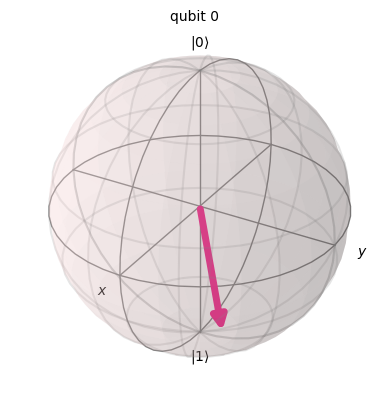

In [197]:
qns: QuantumNativeSimulations = QuantumNativeSimulations()

vector_state: Statevector = qns.statevector_sim(qc)

qv.display_statevector_as_array(psi)
qv.display_bloch_statevector(psi)

In [198]:
qco.bell_state_operation(qc, alice, bob)

In [199]:
qco.bell_state_measurement(qc, alice, bob)

In [200]:
qco.pauli_correction_operation(qc, bob, bsm_z, bsm_x)

In [201]:
vector_state: Statevector = qns.statevector_sim(qc)
qv.display_statevector_as_array(vector_state)

<IPython.core.display.Latex object>

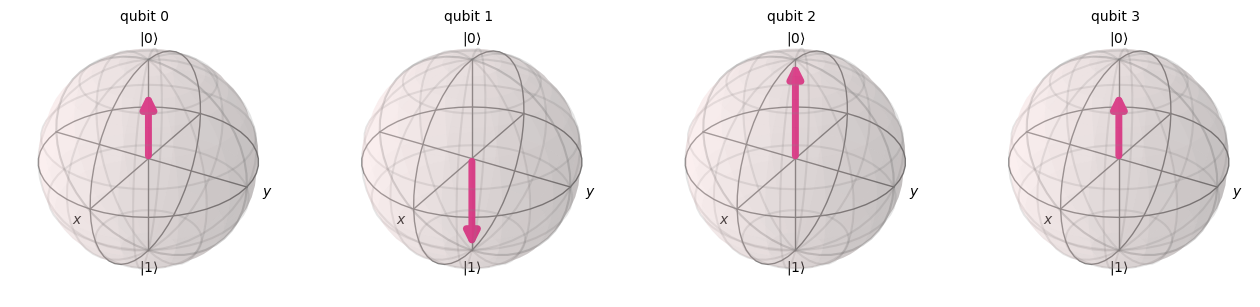

In [202]:
qv.display_bloch_statevector(vector_state)

In [203]:

qc.barrier()
qc.cx(alice[0], bob[1])
qc.h(alice[0])

<IPython.core.display.Latex object>

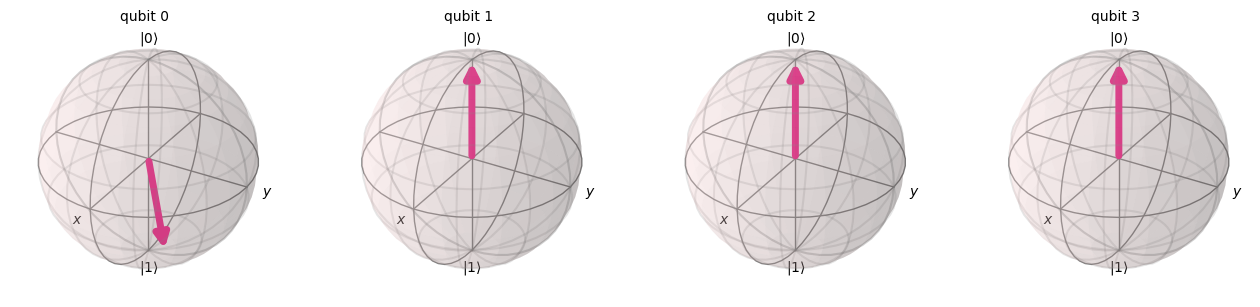

In [204]:
vector_state: Statevector = qns.statevector_sim(qc)
qv.display_statevector_as_array(vector_state)
qv.display_bloch_statevector(vector_state)

We wish to test that our circuit performed the protocol as is expected.

The Initialize instruction, reset our qubit to state, settings it to state $|0\rangle$, before applying gates to turn it from $|0\rangle$ to $|\psi\rangle$.

Since quantum gates are reversible, we can perform an inverse initialization operation, transforming our qubit from $|\psi\rangle$ to $|0\rangle$.

To prove entanglemnt swapping has occurred between Alice and Bob, Alice's first entangled qubit should have been teleported to Bob and entanglement established between $|alice_0\rangle$ and $|bob_1\rangle$. Performing a reverse initialization operation on $|alice_0\rangle$ on the entangled state $|alice_0bob_1\rangle$ now in Bob's node, we exect to measure the state $|00\rangle$ with certainty.

This operation/test acts as our test of entanglement swapping.

In [205]:
inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()

qc.barrier()
qc.append(inverse_init_instruction, [alice[0]])
# qc.append(inverse_init_instruction, [bob[1]])

In [206]:
qc.barrier()
qc.measure(alice[0], coz)
qc.measure(bob[1], cox)

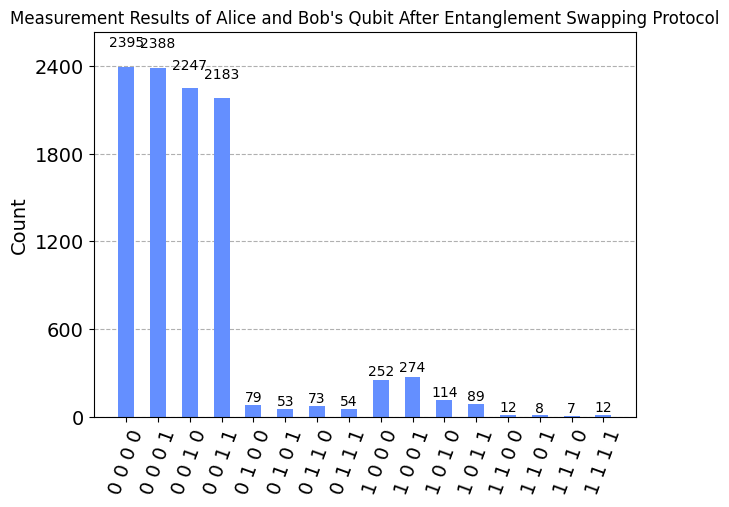

In [207]:
counts: Counts = qns.qasm_sim(qc)
fig = plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubit After Entanglement Swapping Protocol")
fig
# print(counts)

In [208]:
fig.savefig("entanglement_swapping_measurement.jpg", dpi=500)

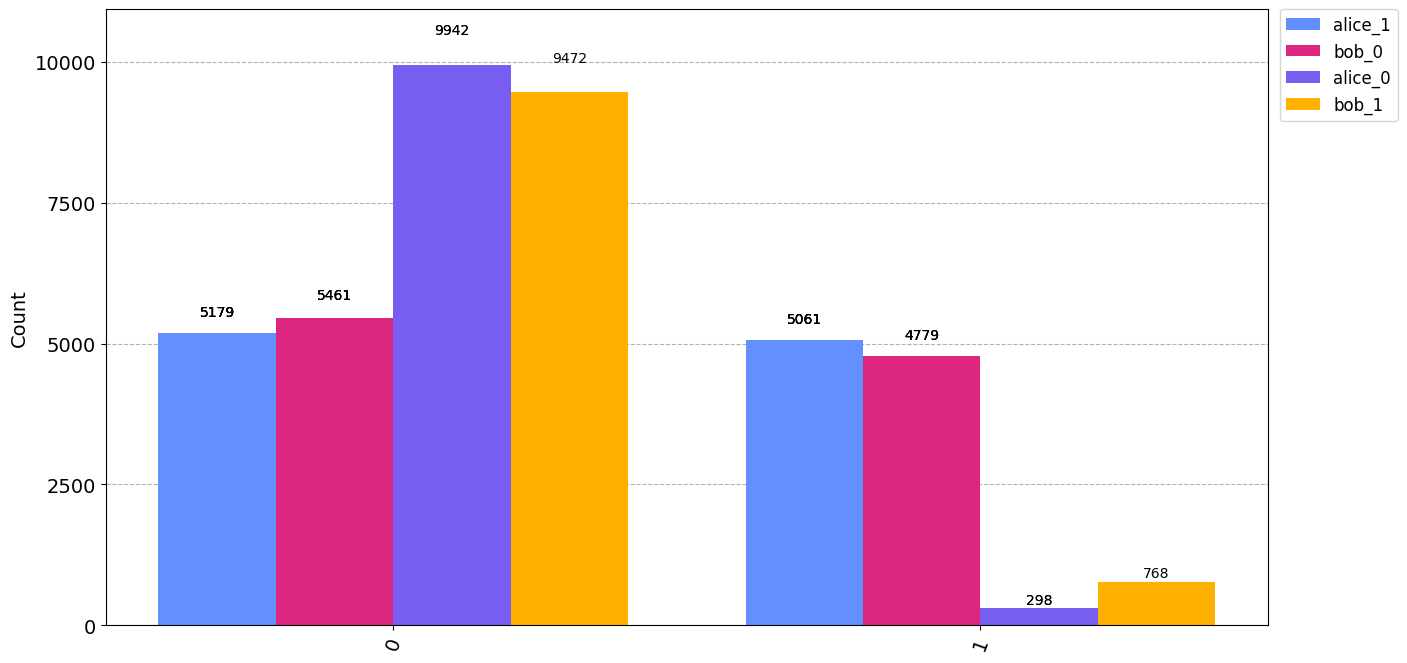

In [209]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["alice_1", "bob_0", "alice_0", "bob_1"]
fig = plot_histogram(qubit_counts, legend=legend, figsize=(15,8))#, title="Probability Measurement Results as Verification of Entanglement Swapping")
# fig.axes[0].set_xlim([0, 2])
fig

In [210]:
fig.savefig("entanglement_swapping_verification.jpg", dpi=500)

As seen in the above graph, we have 100% probability of measuring our entangled qubit $|alice_0bob_1\rangle$ in the state $|00\rangle$. This is the expected result and indicates a successfull entanglement swapping protocol.

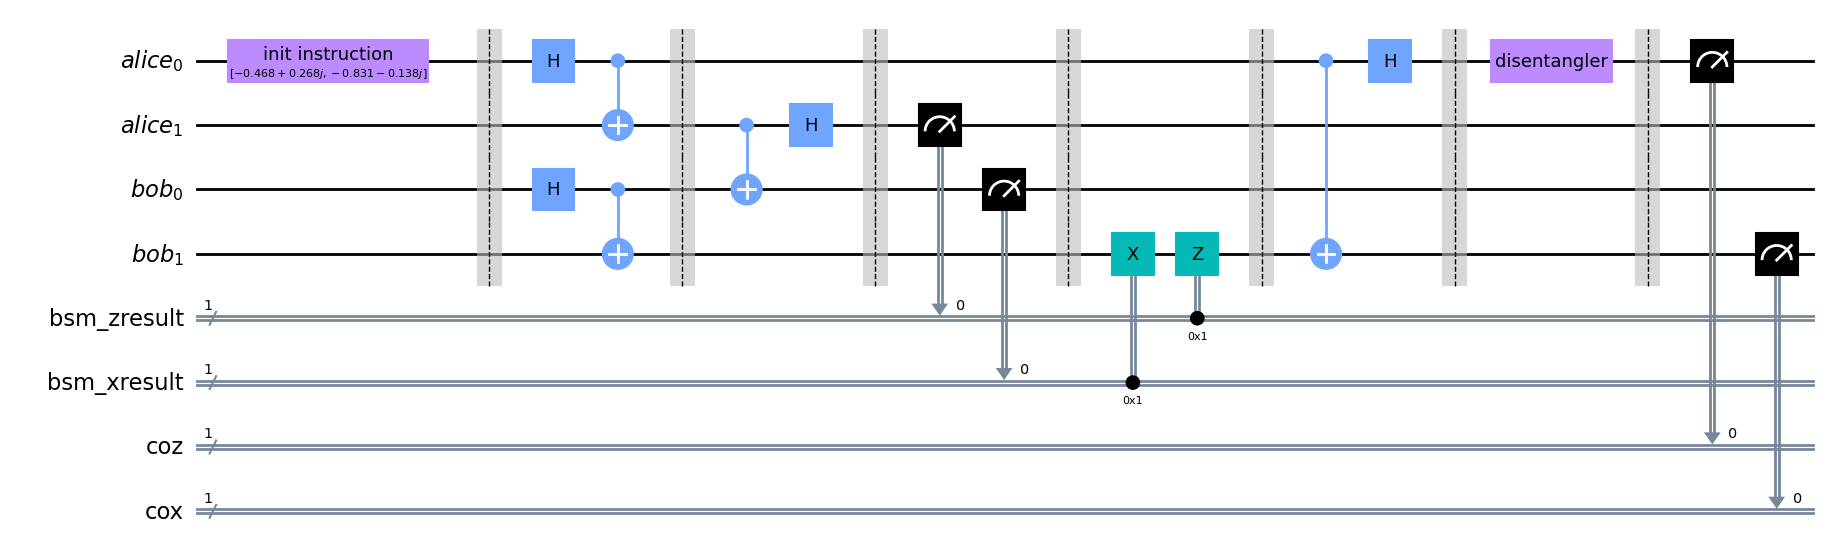

In [211]:
fig = qc.draw("mpl", fold=-1)
fig

In [212]:
fig.savefig("entanglement_swapping.jpg", dpi=500)